In [11]:
from dataset import IAM
from torch.utils.data import DataLoader
from sklearn import preprocessing
import torch
import matplotlib.pyplot as plt
import numpy as np

In [2]:
test_set = IAM('/mnt/d/Machine-Learning/Datasets/iamdataset/uncompressed', split='test')

In [3]:
print(len(test_set))
charset = test_set.charset
print(charset)

1965
 !"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


data = meow.get_entire_dataset()
print(data.head())
print(len(data))
chars = []
data.Transcription.apply(lambda x: chars.extend(list(x)))
chars = ''.join(sorted(set(chars)))
print(chars)

In [4]:
test_set.data.head(10)

,Image,Segmentation,Transcription,Threshold
0,m03-114-00.png,ok,But all three were to the casual,187
1,m03-114-01.png,ok,observation I permitted myself unruffled;,185
2,m03-114-02.png,ok,Mr Septimus reserved and certainly very,184
3,m03-114-03.png,ok,"thoughtful, but that was his habit. Indeed",185
4,m03-114-04.png,ok,we were all invaded by a most tranquil,183
5,m03-114-05.png,ok,"mood. Even the Indian servants relaxed, knowing,",185
6,m03-114-06.png,ok,"so Mr Gilberto told us, that the wild and",186
7,m03-114-07.png,ok,savage tribes never approached this region: at,185
8,m03-114-08.png,ok,"any rate they remained with us, perhaps",185
9,m03-114-09.png,ok,"for such protection as our presence, or Mrs",187


observation I permitted myself unruffled;


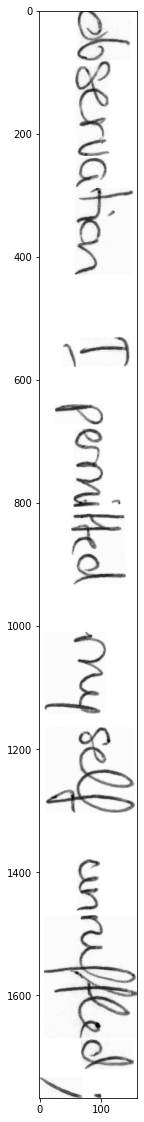

In [17]:
img, trans = test_set[1]
out = img.rotate(-90, expand=True)
plt.figure(figsize=(50, 20))
plt.imshow(np.array(out), cmap='gray')
print(trans)


(1767, 159)
torch.Size([1, 1024, 128])


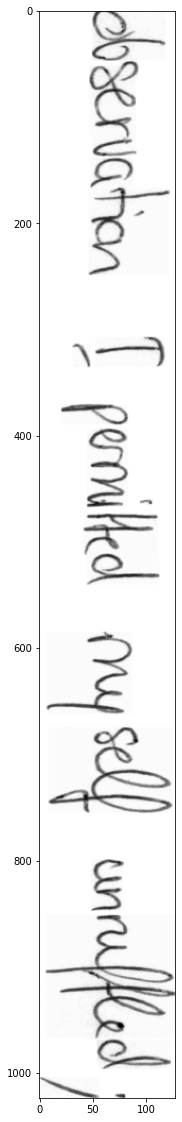

In [21]:
from torchvision.transforms import Compose, ToTensor, Resize
print(np.array(out).shape)
transforms = Compose([
    Resize((1024, 128)),
    ToTensor()
])
img_transformed = transforms(out)
plt.figure(figsize=(10, 20))
plt.imshow(img_transformed[0], cmap='gray')
print(img_transformed.shape)

observation I permitted myself unruffled;


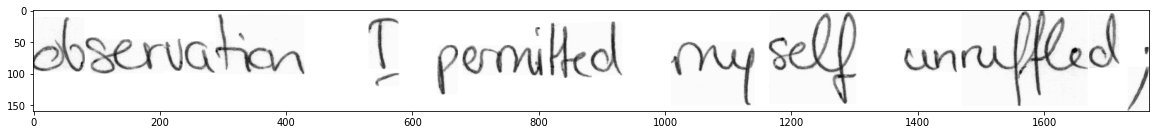

In [9]:
img, trans = test_set[1]
plt.figure(figsize=(20, 10))
plt.imshow(img, cmap='gray')
print(trans)

In [7]:
class CollateEncoder:
    def __init__(self, charset):
        self.char_dic = {char:index for index, char in enumerate(charset, 1)}
        
    def __call__(self, batch):
        images, transcriptions = zip(*batch)
        
        images = torch.stack(images, dim=0)
        
        target_lengths = [len(line) for line in transcriptions] 
        target_lengths = torch.tensor(target_lengths, dtype=torch.long)
        targets = []
        for line in transcriptions:
            targets.extend([self.char_dic[char] for char in line])
        targets = torch.tensor(targets, dtype=torch.long)   
        
        return images, targets, target_lengths
        
collater = CollateEncoder(charset)


test_loader = DataLoader(test_set, batch_size=120, shuffle=True, collate_fn=collater)

images, targets, target_lens = next(iter(test_loader))

torch.Size([120, 1, 128, 1024])


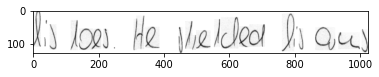

In [8]:
plt.imshow(images[0][0], cmap='gray')
print(images.shape)

In [40]:
from torchvision.transforms import Normalize

In [47]:
import random

In [22]:
lstm = torch.nn.LSTM(input_size=1024, hidden_size=512, num_layers=2, 
                            bidirectional=True, batch_first=True)
linear1 = torch.nn.Linear(1024, 256)
linear2 = torch.nn.Linear(256, 80)

In [23]:
out, _ = lstm(torch.rand(4, 32, 1024))
out = linear1(out)
out = linear2(out)
out.shape

torch.Size([4, 32, 80])

In [31]:
a, b = zip(*([12, 12], [13, 13]))

In [32]:
a

(12, 13)

In [33]:
b

(12, 13)

In [13]:
import numpy as np

In [17]:
arr = np.array([[12, 13, 12], [32, 33, 32], [14, 15, 14], [12, 32, 14]])
u, i = np.unique(arr.flatten(), return_inverse=True)
background = int(u[np.argmax(np.bincount(i))])
background

12

In [18]:
np.transpose(arr)

array([[12, 32, 14, 12],
       [13, 33, 15, 32],
       [12, 32, 14, 14]])

In [21]:
torch.transpose(torch.from_numpy(arr))

TypeError: transpose() received an invalid combination of arguments - got (Tensor), but expected one of:
 * (Tensor input, name dim0, name dim1)
 * (Tensor input, int dim0, int dim1)
